In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
folder1='E:/dataset'
folder2='E:/training_data'
img1=os.listdir(folder1)
img2=os.listdir(folder2)

In [7]:
similar=[]
#similar images pair
def get_similar_images(folder1,folder2):
    similar=[]
    for img1,img2 in zip(os.listdir(folder1),os.listdir(folder2)):
        similar.append([folder1+'/'+img1,folder2+'/'+img2,1])

    return similar
        

In [ ]:
similar=get_similar_images(folder1,folder2)
print(similar)

In [9]:
negative_pairs=[]
def get_negative_images(folder1,folder2):
    negative_pairs=[]
    for img1_name in img1:
        img1_path = os.path.join(folder1, img1_name)
        img2_name = np.random.choice(img2)
        img2_path = os.path.join(folder2, img2_name)
        #check if the pair is not on similar list
        if [img1_path, img2_path] not in similar:
         negative_pairs.append([img1_path, img2_path,0])
    return negative_pairs

In [10]:
negative_pairs=get_negative_images(folder1,folder2)

In [11]:
pairs=similar+negative_pairs
data=pd.DataFrame(pairs,columns=['image1','image2','label'])
data.shape

(6306, 3)

In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
# Define Siamese model architecture
def create_siamese_model(input_shape):
    base_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu')
    ])
    
    input1 = tf.keras.Input(shape=input_shape)
    input2 = tf.keras.Input(shape=input_shape)
    
    output1 = base_model(input1)
    output2 = base_model(input2)
    
    distance = tf.keras.layers.Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]))([output1, output2])
    
    # Modify the output layer to have a single unit with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(distance)
    
    siamese_model = tf.keras.Model(inputs=[input1, input2], outputs=output)
    
    return siamese_model

In [14]:

from sklearn.utils import shuffle


def siamese_data_generator(data, batch_size, input_shape):
    datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
    )
    
    num_samples = len(data)
    while True:
        data = shuffle(data)
        for i in range(0, num_samples, batch_size):
            batch_data = data.iloc[i:i + batch_size]
            
            batch_images1 = []
            batch_images2 = []
            batch_labels = []
            for idx, row in batch_data.iterrows():
                img1 = load_img(row['image1'], target_size=input_shape[:2])
                img2 = load_img(row['image2'], target_size=input_shape[:2])
                
                img1 = img_to_array(img1)
                img1 = datagen.random_transform(img1)
                img1 = img1 / 255.0
                
                img2 = img_to_array(img2)
                img2 = datagen.random_transform(img2)
                img2 = img2 / 255.0
                
                batch_images1.append(img1)
                batch_images2.append(img2)
                batch_labels.append(row['label'])
            
            yield [np.array(batch_images1), np.array(batch_images2)], np.array(batch_labels)



In [15]:
input_shape = (128, 128, 3)

In [16]:
siamese_model = create_siamese_model(input_shape)

siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 32

In [17]:
train_generator = siamese_data_generator(train_data, batch_size, input_shape)
val_generator = siamese_data_generator(val_data, batch_size, input_shape)

In [18]:
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

In [39]:
with(tf.device('/GPU:0')):  
   history = siamese_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20,
                            validation_data=val_generator, validation_steps=validation_steps)


Epoch 1/20
157/157 [==============================] - 549s 4s/step - loss: 0.6806 - accuracy: 0.5466 - val_loss: 0.6360 - val_accuracy: 0.6458
Epoch 2/20
157/157 [==============================] - 655s 4s/step - loss: 0.5877 - accuracy: 0.7029 - val_loss: 0.5079 - val_accuracy: 0.7620
Epoch 3/20
157/157 [==============================] - 583s 4s/step - loss: 0.4748 - accuracy: 0.7833 - val_loss: 0.4617 - val_accuracy: 0.7997
Epoch 4/20
157/157 [==============================] - 575s 4s/step - loss: 0.4349 - accuracy: 0.8075 - val_loss: 0.5081 - val_accuracy: 0.7796
Epoch 5/20
157/157 [==============================] - 597s 4s/step - loss: 0.3951 - accuracy: 0.8280 - val_loss: 0.3909 - val_accuracy: 0.8341
Epoch 6/20
157/157 [==============================] - 618s 4s/step - loss: 0.3850 - accuracy: 0.8248 - val_loss: 0.3863 - val_accuracy: 0.8373
Epoch 7/20
157/157 [==============================] - 594s 4s/step - loss: 0.3660 - accuracy: 0.8416 - val_loss: 0.3834 - val_accuracy: 0.8325

In [ ]:
#file_path=siamese_model.save('SNN1.h5')

In [ ]:
 
history_df = pd.DataFrame(history.history)
history_df.to_csv('history.csv', index=False)

In [19]:
df=pd.read_csv('history.csv')
df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.680625,0.546576,0.635956,0.645833
1,0.587690,0.702913,0.507897,0.762019
2,0.474836,0.783320,0.461663,0.799679
3,0.434857,0.807462,0.508054,0.779647
4,0.395119,0.828013,0.390925,0.834135


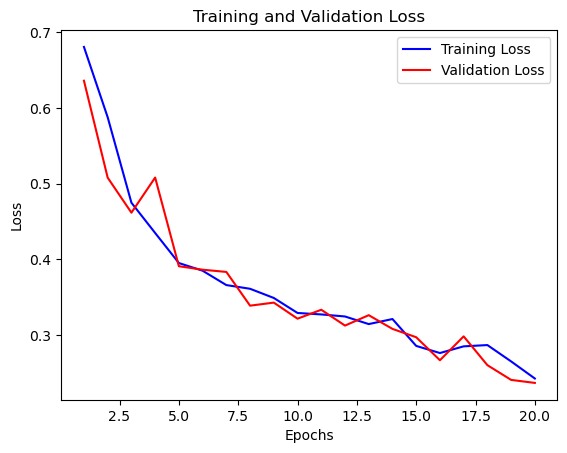

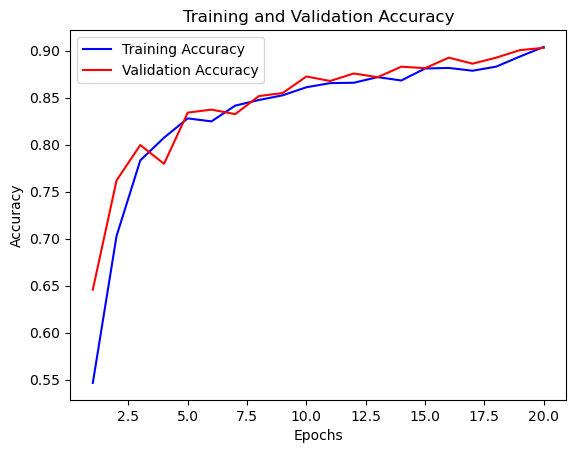

In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' contains your training history
train_loss = df['loss']
val_loss = df['val_loss']
train_acc = df['accuracy']
val_acc = df['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting Loss
plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#save as image 
plt.savefig('loss.png')
plt.show()

# Plotting Accuracy
plt.figure()
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')
plt.legend()
plt.show()
#confusion matrix



In [45]:
import pickle


with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:

history_df.to_csv('SNN1.csv', index=False)


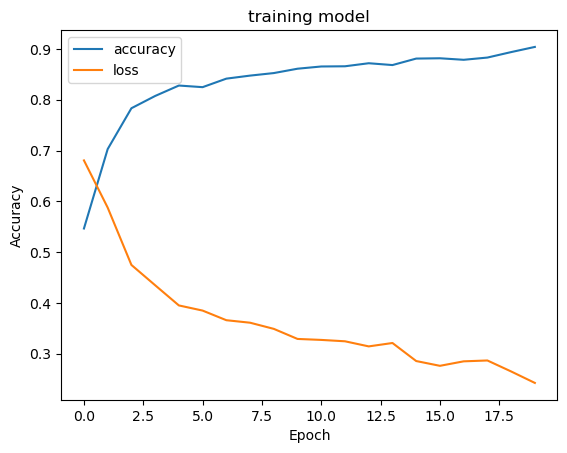

In [22]:
#plot training and validation accuarcy and loss
import matplotlib.pyplot as plt
plt.plot(df['accuracy'])
plt.plot(df['loss'])
plt.title('training model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()


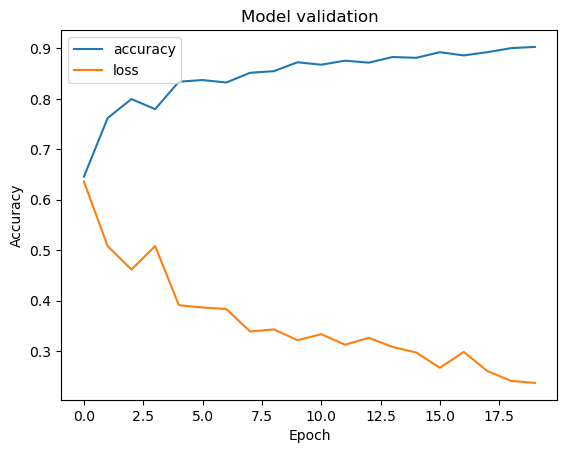

In [23]:
plt.plot(df['val_accuracy'])
plt.plot(df['val_loss'])
plt.title('Model validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [50]:
model=tf.keras.models.load_model('E:/SNN1.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          3304640     ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

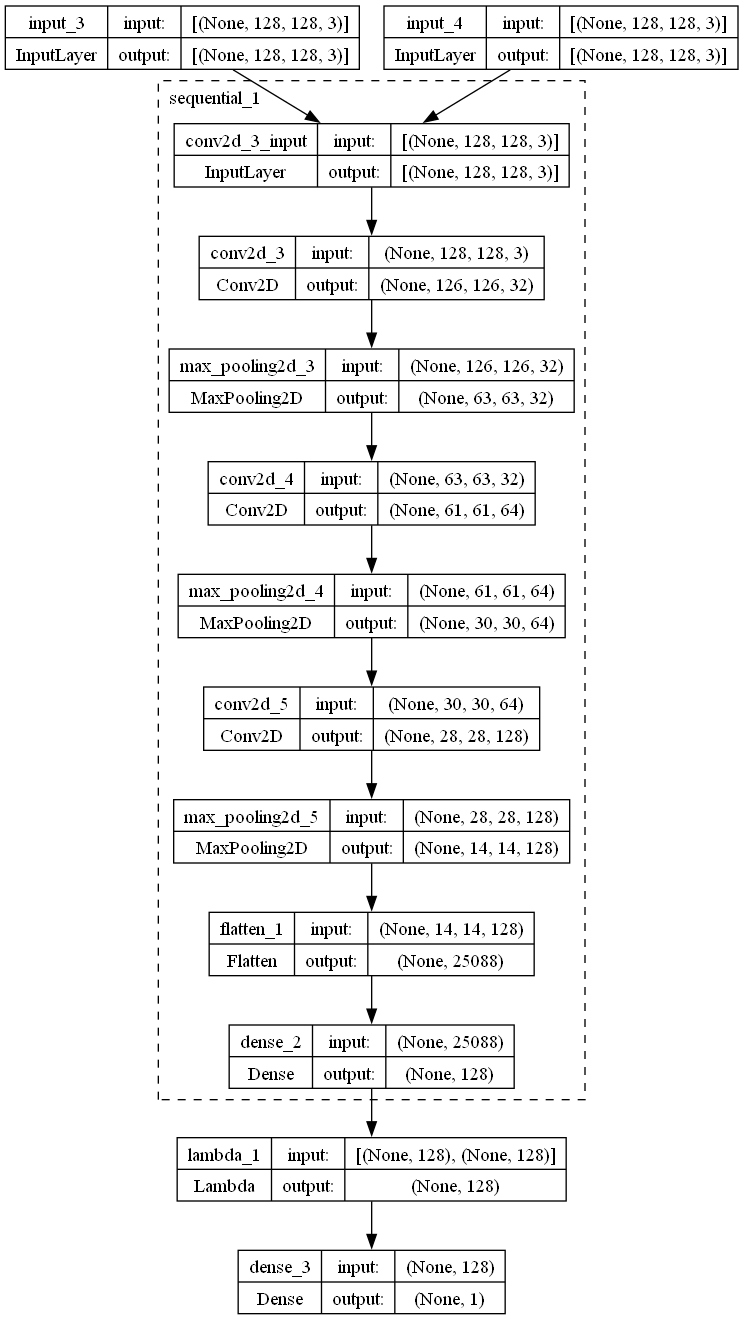

In [51]:
model.summary()
# visualize all the model layers with sequential model
from tensorflow.keras.utils import plot_model
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,rankdir='TB',expand_nested=True)


